In [1]:
from scipy.stats import norm
import numpy as np
import sympy
import scipy
import torch
from numpy import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import quad
from scipy.stats import norm
emc = float( sympy.S.EulerGamma.n(10) )
from tteVAMP.problem import *

These functions are used to generate synthetic data

In [2]:
def sim_pheno_ExpGamma(X, beta, mu, h2, kappa):
    # logY_i = mu + xi beta + sigma * wi, wi = standard Normal variable
    # beta is mx1 vector 
    # mu is nx1 vector 
    [n,m] = X.shape
    g = np.matmul(X, beta)
    sigmaG = np.var(g)
    sigmaE = np.sqrt( (1/h2-1) * sigmaG )
    theta = sigmaE / scipy.special.polygamma(1, kappa)
    # mu tilde
    mut = mu + g - theta * scipy.special.polygamma(0, kappa)
    y = random.gamma(shape=kappa, scale=theta, size=[n,1]) + mut
    return y, kappa, theta, mut

def sim_pheno_LogNormal(X, beta, mu, h2):
    # logY_i = mu + xi beta + sigma * wi, wi = standard Normal variable
    # beta is mx1 vector 
    # mu is nx1 vector 
    [n,m] = X.shape
    g = np.matmul(X, beta)
    sigmaG = np.var(g)
    sigma = np.sqrt( (1/h2-1) * sigmaG )
    w = random.normal(loc=0.0, scale=1.0, size=[n,1])
    y = np.exp(mu + g + sigma * w)
    return y, sigma

# Simulate the input X
def sim_geno(n,m,p): # checked!
    X = random.binomial(2, p, size=[n,m]) / np.sqrt(n)
    # for debugging purposes we simulate a Gaussian matrix and scale it 
    #X = random.normal(loc=0.0, scale=1.0, size=[n,m]) / np.sqrt(n)
    return X

# Simulate the coefficients beta
def sim_beta(m, la, sigma): # checked!
    beta = random.normal(loc=0.0, scale=np.sqrt(sigma), size=[m,1]) # scale = standard deviation
    beta *= random.binomial(1, la, size=[m,1])
    return beta

def mathematica_evd(n, loc, scale):
    wi = np.random.gumbel(loc=loc, scale=scale, size=[n, 1])
    return wi

# Simulate the outcomes Y
def sim_pheno_Weibull(X, beta, mu, h2):
    [n,m] = X.shape
    g = np.matmul(X, beta)
    sigmaG = np.var(g)
    varwi = np.pi * np.pi / 6
    c = np.sqrt((1/h2-1) * sigmaG / varwi)
    
    wi = -mathematica_evd(n=n, loc=-0, scale=1.0)
    # wi = -np.random.gumbel(loc=0, scale=1.0, size=[n, 1])

    y = np.exp(mu + g + c * (wi + emc) )
    # An equivalent formulation would be: 
    # y = np.exp(-mathematica_evd(n=n, loc = -(mu+g+c*emc), scale=c))
    alpha = 1.0 / c
    return y, alpha


def sim_model(problem,h2,p, kappa=None):
    X = sim_geno(problem.n, problem.m, p)
    beta = sim_beta(problem.m, problem.prior_instance.la, problem.prior_instance.sigmas)
    mu = np.zeros((problem.n,1))
    print(problem.model)
    if problem.model == 'Weibull':
        y, alpha = sim_pheno_Weibull(X, beta, mu, h2)
        return X, beta, y, alpha
    elif problem.model == 'Gamma':
        return X, beta, sim_pheno_ExpGamma(X, beta, mu, h2, kappa)
    elif problem.model == 'LogNormal':
        return X, beta, sim_pheno_LogNormal(X, beta, mu, h2)
    else:
        raise Exception(problem.model, " is not a valid model. Allowed models are: 'Weibull', 'Gamma' and 'LogNormal'")

Note: since this notebook focuses on the Weibull distribution, the functions in the following block are unused and are presented here just for completeness

In [3]:
# LogNormal model
def den_z_LogNormal(p1, tau1, y, sigma, mu):
    out = (np.log(y) - mu + p1 * tau1 * sigma * sigma) / (1 + tau1 * sigma * sigma)
    return out

def der_den_z_LogNormal(p1, tau1, y, sigma, mu): 
    # z = tau1 * sigma * sigma / (1 + tau1 * sigma * sigma)
    # return nom / den
    pass

# ExpGamma model
def den_z_non_lin_eq_Gamma(z, tau1, p1, y, kappa, theta, mu): 
    res = theta * (np.log(theta * tau1 * (z-p1) + kappa) - scipy.special.polygamma(0, kappa)) + (np.log(y) - mu - z)
    return res

def den_z_Gamma(p1, tau1, y, kappa, theta, mu): 
    n,_ = p1.shape
    out = np.zeros((n,1))
    for i in range(0, n):
        out[i] = scipy.optimize.fsolve(den_z_non_lin_eq_Gamma, x0 = p1[i], args=(tau1, p1[i], y[i], kappa, theta, mu) )
    return out

def der_den_z_Gamma(p1, tau1, y, kappa, theta, mu):
    z = den_z(p1, tau1, y, kappa, theta, mu)
    out = tau1 * theta ( tau1 * theta - tau1 * (z-p1) )
    return out

Denoisers used in the VAMP algorithm (infere function)

In [4]:
# Weibull model
def den_z_non_lin_eq_Weibull(z, tau1, p1, y, alpha, mu):
    """
    Performs MAP estimation of z
    Defines the objective to maximize
    Maximizing the expression below is equivalent to maximizing the likelihood of z
    We can treat the components of z as independent under the simplifying assumptions
    """ 
    res = tau1 * (z-p1) + alpha - alpha * np.power(y, alpha) * np.exp(- alpha * (mu + z) - emc)
    return res

def den_z_Weibull(p1, tau1, y, alpha, mu): 
    n,_ = p1.shape
    out = np.zeros((n,1))
    for i in range(0, n):
        out[i] = scipy.optimize.fsolve(den_z_non_lin_eq_Weibull, x0 = p1[i], args=(tau1, p1[i], y[i], alpha, mu) )
    return out

# denoiser of z
def den_z(p1, tau1, y, problem):
    #  print(f"Inside denoiser den_z! {problem.model}")
     d = problem.prior_instance.distribution_parameters
    #  print(f"Mu: \n\n\n")
    #  print(d['mu'])
     if problem.model == 'Weibull':
         
         alpha, mu = None, None
         if 'alpha' in d: alpha = d['alpha']
         if 'mu' in d: mu = d['mu'][0][0]
        #  print(f"alpha: {alpha}, mu: {mu}")
         r = den_z_Weibull(p1, tau1, y, alpha, mu)
        #  print(f"r: {r}")
         return r
     elif problem.model == 'Gamma':
         theta, kappa, mu = None, None, None
         if 'theta' in d: alpha = d['theta']
         if 'kappa' in d: alpha = d['kappa']
         if 'mu' in d: mu = d['mu'][0][0]
         return den_z_Gamma(p1, tau1, y, kappa, theta, mu)
     elif problem.model == 'LogNormal':
         sigma, mu = None, None
         if 'sigma' in d: alpha = d['sigma']
         if 'mu' in d: mu = d['mu'][0][0]
         return den_z_LogNormal(p1, tau1, y, sigma, mu)      

def der_den_z(p1, tau1, y, problem):
     d = problem.prior_instance.distribution_parameters
     if problem.model == 'Weibull':
         alpha, mu = None, None
         if 'alpha' in d: alpha = d['alpha']
         if 'mu' in d: mu = d['mu'][0][0]
         r = der_den_z_Weibull(p1, tau1, y, alpha, mu)
         return r
     elif problem.model == 'Gamma':
         theta, kappa, mu = None, None, None
         if 'theta' in d: alpha = d['theta']
         if 'kappa' in d: alpha = d['kappa']
         if 'mu' in d: mu = d['mu'][0][0]
         return der_den_z_Gamma(p1, tau1, y, kappa, theta, mu)
     elif problem.model == 'LogNormal':
         sigma, mu = None, None
         if 'sigma' in d: alpha = d['sigma']
         if 'mu' in d: mu = d['mu'][0][0]
         return der_den_z_LogNormal(p1, tau1, y, sigma, mu) 

def der_den_z_Weibull(p1, tau1, y, alpha, mu):
    z = den_z(p1, tau1, y, Problem(model = 'Weibull', mu=np.full((y.shape[0],1), 0), alpha=alpha))
    nom = tau1
    den = tau1 + alpha * alpha * np.power(y, alpha) * np.exp(- alpha * (mu + z) - emc)
    return nom / den

# denoiser of the signal beta
def den_beta(r,gam1,problem): # checked!
    """
    This function returns the conditional expectation of the coefficients beta given the noisy estimate r
    The expectation is of the posterior distribution with the form of Spike and Slab mixture of Gaussians
    """
    prior = problem.prior_instance
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1)) # scale = standard deviation
    B = prior.la * norm.pdf(r, loc=0, scale=np.sqrt(prior.sigmas[0] + 1.0/gam1))
    ratio = gam1 * r / (gam1 + 1/prior.sigmas[0]) * B / (A + B)
    return ratio

def der_den_beta(r,gam1,problem): # checked!
    prior = problem.prior_instance
    # Derivative of the Gaussians with respect to r
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1))
    B = prior.la * norm.pdf(r, loc=0, scale=np.sqrt(prior.sigmas[0] + 1.0/gam1))
    print("B / (A+B) = ", B[1] / (A[1]+B[1]))
    Ader = A * (-r*gam1)
    Bder = B * (-r) / (prior.sigmas[0] + 1.0/gam1)
    BoverAplusBder = ( Bder * A - Ader * B ) / (A+B) / (A+B)
    print("gam1 / (gam1 + 1/sigma) = ", gam1 / (gam1 + 1/prior.sigmas[0]))
    print("alpha1 part I = ", gam1 / (gam1 + 1/prior.sigmas[0]) * B[1] / (A[1] + B[1]))
    print("alpha2 part II = ", BoverAplusBder[1] * r[1] * gam1 / (gam1 + 1.0/prior.sigmas[0]) )
    ratio = gam1 / (gam1 + 1/prior.sigmas[0]) * B / (A + B) + BoverAplusBder * r * gam1 / (gam1 + 1.0/prior.sigmas[0])
    return ratio

Corrected EM updates

In [5]:
### WEIBULL MODEL ###
def update_Weibull_alpha_eq(alpha, y, mu, z_hat, xi):
    n,_ = y.shape
    out = np.zeros(n)
    res = np.log(y) - mu - z_hat
    out = n / alpha + np.sum(res) - np.exp(-emc) * np.sum( np.exp(alpha * res + (alpha**2)/2/xi) * (res + alpha/xi) )
    return out

def update_Weibull_alpha(y, mu, z_hat, alpha_old, xi):
    # y.shape = [n,1]
    # z_hat.shape = [n,1]
    alpha_new = scipy.optimize.fsolve(update_Weibull_alpha_eq, x0 = alpha_old, args=(y, mu, z_hat, xi))
    if isinstance(alpha_new, np.ndarray) or isinstance(alpha_new, list): alpha_new = float(alpha_new[0])
    return alpha_new

def update_Weibull_mu(y, z_hat, alpha, xi):
    # y.shape = [n,1]
    # z_hat.shape = [n,1]
    n,_ = y.shape
    mu_new = - np.log(n) / alpha - emc/alpha + alpha / 2 / xi + 1 / alpha * np.log(np.sum(np.exp(alpha*(np.log(y) - z_hat))))
    if isinstance(mu_new, np.ndarray) or isinstance(mu_new, list): mu_new = float(mu_new[0])
    return mu_new

In [6]:
def update_params(y, mu, z1_hat, alpha, predicted_xi, update_Weibull_alpha, update_Weibull_mu, mus, alphas, update_alpha, update_mu, it):
    if update_alpha:
        alpha_new = update_Weibull_alpha(y, mu, z1_hat, alpha, predicted_xi)
        alphas.append(alpha_new)
        alpha = alpha_new
    if it > 5:
        if update_mu:
            mu_new = update_Weibull_mu(y, z1_hat, alpha, predicted_xi)
            mus.append(mu_new)
            mu = mu_new
        else:
            mus.append(mu)
    else:
        mus.append(mu)
    return mu, alpha

Diagnostic plots

In [7]:
def plot_metrics(corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, dl_dmus, a, p, correct_mu, correct_alpha, n, m):
    plt.figure(figsize=(20, 10))
    
    # Overall title
    plt.suptitle(f"Working with {n}x{m} matrix", fontsize=16)

    # Plotting corr_x
    plt.subplot(3, 4, 1)
    plt.ylabel('corr_x')
    plt.plot(range(len(corrs_x)), corrs_x, 'ro-')

    # Plotting l2_err_x
    plt.subplot(3, 4, 2)
    plt.ylabel('l2_err_x')
    plt.plot(range(len(l2_errs_x)), l2_errs_x, 'ro-')

    # Plotting corr_z
    plt.subplot(3, 4, 3)
    plt.ylabel('corr_z')
    plt.plot(range(len(corrs_z)), corrs_z, 'bo-')

    # Plotting l2_err_z
    plt.subplot(3, 4, 4)
    plt.ylabel('l2_err_z')
    plt.plot(range(len(l2_errs_z)), l2_errs_z, 'bo-')

    # Plotting mu evolution
    plt.subplot(3, 4, 5)
    plt.ylabel('mu')
    plt.plot(range(len(mus)), mus, 'go-')
    plt.axhline(y=correct_mu, color='r', linestyle='--', label='Correct mu')
    plt.legend()

    # Plotting alpha evolution
    plt.subplot(3, 4, 6)
    plt.ylabel('alpha')
    plt.plot(range(len(alphas)), alphas, 'go-')
    plt.axhline(y=correct_alpha, color='r', linestyle='--', label='Correct alpha')
    plt.legend()

    # Plotting Actual vs Predicted Scatter Plot in the last cell
    plt.subplot(3, 4, 7)
    indices = range(len(a))
    plt.scatter(indices, a, color='blue', label='Actual')
    plt.scatter(indices, p, color='red', label='Predicted')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title('Actual vs Predicted Scatter Plot')
    plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout to make space for the suptitle
    plt.show()


EM VAMP loop

In [8]:
def infere(X, y, gam1, r1, tau1, p1, problem, maxiter, beta_true, update_mu, update_alpha):

    alpha = problem.prior_instance.distribution_parameters['alpha']
    mu = problem.prior_instance.distribution_parameters['mu'][0][0]

    #computing SVD decomposition of X
    [n,m] = X.shape
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    print("s.shape = ", s.shape)
    Xbeta_true = X @ beta_true

    #storing measure of recovery quality
    l2_errs_x = []
    corrs_x = []
    l2_errs_z = []
    corrs_z = []
    mus = [mu]
    alphas = [alpha]
    actual_xis = []
    predicted_xis = []
    dl_dmus = []
    z1_hats = []
    x1_hats = []
    
    for it in range(maxiter):
        print("**** iteration = ", it, " **** \n" )
        # Denoising x (the effect sizes)
        print("->DENOISING")
        ############################################################
        # Conditional expectation of x given r and the parameters of the prior distribution of x
        # This is applied elementwise to r1
        ############################################################
        x1_hat = den_beta(r1, gam1, problem)
        x1_hats.append(x1_hat)
        ############################################################
        print("x1_hat[2] = ", x1_hat[2])
        if np.linalg.norm(x1_hat) != 0:
            # Cosine similarity
            # corr = np.dot(x1_hat.transpose(), beta_true) / np.linalg.norm(x1_hat) / np.linalg.norm(beta_true)
            corr = np.corrcoef(np.squeeze(x1_hat, axis=-1), np.squeeze(beta_true, axis=-1))
            print("corr(x1_hat, beta_true) = ", corr[0, 1])
            corrs_x.append(corr[0, 1])
            l2_err = np.linalg.norm(x1_hat - beta_true) / np.linalg.norm(beta_true)
            print("l2 error for x1_hat = ", l2_err)
            l2_errs_x.append(l2_err)
        ############################################################
        alpha1 = np.mean( der_den_beta(r1, gam1, problem) )
        print("alpha1 = ", alpha1)
        gam2 = gam1 * (1-alpha1) / alpha1
        r2 = (x1_hat - alpha1 * r1) / (1-alpha1)
        print("true gam2 = ", 1.0 / np.var(r2 - beta_true))
        print("gam2 = ", gam2)
        # Denoising z (the genetic predictor)
        z1_hat = den_z(p1, tau1, y, problem)
        z1_hats.append(z1_hat)
        ############################################################
        # Cosine similarity
        # Note: this correlation expression could be wrong!
        # corr = np.dot(z1_hat.transpose(), Xbeta_true) / np.linalg.norm(z1_hat) / np.linalg.norm(Xbeta_true)
        corr = np.corrcoef(np.squeeze(z1_hat, axis=-1), np.squeeze(Xbeta_true, axis=-1))
        print("corr(z1_hat, X*beta_true) = ", corr[0, 1])
        corrs_z.append(corr[0, 1])
        l2_err = np.linalg.norm(z1_hat - Xbeta_true) / np.linalg.norm(Xbeta_true)
        print("l2 error for z1_hat = ", l2_err)
        l2_errs_z.append(l2_err)
        
        ############################################################
        beta_1 = np.mean(der_den_z(p1, tau1, y, problem) )
        print("v1 = ", beta_1)
        tau2 = tau1 * (1-beta_1) / beta_1
        p2 = (z1_hat - beta_1 * p1) / (1-beta_1)
        print("true tau2 = ", 1.0 / np.var(p2 - Xbeta_true))
        print("tau2 =", tau2)

        predicted_xi = tau1 / beta_1
        predicted_xis.append(predicted_xi)
        actual_xi = 1 / np.var(X@beta_true-z1_hat)
        actual_xis.append(actual_xi)

        
        # LMMSE estimation of x
        print("->LMMSE")
        dk = 1.0 / (tau2 * s * s + gam2)
        x2_hat = vh.transpose() @ np.diag(dk) @ (tau2 * np.diag(s).transpose() @ u.transpose() @ p2 + gam2 * vh @ r2)

        ############################################################
        # Cosine similarity
        print("corr(x2_hat, beta_true) = ", np.dot(x2_hat.transpose(), beta_true) / np.linalg.norm(x2_hat) / np.linalg.norm(beta_true))
        print("l2 error for x2_hat = ", np.linalg.norm(x2_hat - beta_true) / np.linalg.norm(beta_true))
        ############################################################

        alpha2 = np.sum( gam2 / (tau2 * s * s + gam2) ) / m
        print("alpha2 = ", alpha2)
        gam1 = gam2 * (1-alpha2) / alpha2
        r1 = (x2_hat - alpha2 * r2) / (1-alpha2)
        print("true gam1 = ", 1.0 / np.var(r1 - beta_true))
        print("gam1 = ", gam1)
        
        # LMMSE estimation of z
        z2_hat = np.matmul(X, x2_hat)

        mu, alpha = update_params(y, mu, z1_hat, alpha, predicted_xi, update_Weibull_alpha, update_Weibull_mu, mus, alphas, update_alpha, update_mu, it)
        problem.prior_instance.distribution_parameters['alpha'] = alpha
        problem.prior_instance.distribution_parameters['mu'] = np.full((y.shape[0],1), mu)

        
        ############################################################
        # Cosine similarity
        print("corr(z2_hat, beta_true) = ", np.dot(z2_hat.transpose(), Xbeta_true) / np.linalg.norm(z2_hat) / np.linalg.norm(Xbeta_true))
        print("l2 error for z2_hat = ", np.linalg.norm(z2_hat - Xbeta_true) / np.linalg.norm(Xbeta_true))
        ############################################################

        beta2 = (1-alpha2) * m / n
        tau1 = tau2 * (1-beta2) / beta2
        p1 = (z2_hat - beta2 * p2) / (1-beta2)
        print("true tau1 = ", 1.0 / np.var(p1 - Xbeta_true))
        print("tau1 = ", tau1)
        print("\n")


    return x1_hat, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, actual_xis, predicted_xis, dl_dmus, z1_hats

Experiments with synthetic genetic matrices X of varying sizes

Weibull
gam1 =  0.01
tau1 =  0.1
alpha =  2.9361235628007685
s.shape =  (800,)
**** iteration =  0  **** 

->DENOISING
x1_hat[2] =  [0.]
B / (A+B) =  [0.39880656]
gam1 / (gam1 + 1/sigma) =  0.009900990099009901
alpha1 part I =  [0.00394858]
alpha2 part II =  [0.]
alpha1 =  0.003948579767497003
true gam2 =  2.3722202522924425
gam2 =  2.5225561565998147


/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_34435/2211291991.py:16: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  out[i] = scipy.optimize.fsolve(den_z_non_lin_eq_Weibull, x0 = p1[i], args=(tau1, p1[i], y[i], alpha, mu) )


corr(z1_hat, X*beta_true) =  0.6915412287958037
l2 error for z1_hat =  0.8135482947197579
v1 =  0.034865534927765424
true tau2 =  6.942772700920337
tau2 = 2.768161931465571
->LMMSE
corr(x2_hat, beta_true) =  [[0.6009897]]
l2 error for x2_hat =  0.8344342138771821
alpha2 =  0.7233489312901739
true gam1 =  2.0886972482892916
gam1 =  0.9647734674317756
corr(z2_hat, beta_true) =  [[0.78540348]]
l2 error for z2_hat =  0.6858488214414524
true tau1 =  7.2894657102883675
tau1 =  7.237806758173005


**** iteration =  1  **** 

->DENOISING
x1_hat[2] =  [-0.09795812]
corr(x1_hat, beta_true) =  0.6358040321379221
l2 error for x1_hat =  0.831951160840684
B / (A+B) =  [0.36713011]
gam1 / (gam1 + 1/sigma) =  0.49103547224345656
alpha1 part I =  [0.18027391]
alpha2 part II =  [0.04531767]
alpha1 =  0.2151385856726094
true gam2 =  2.576395355056953
gam2 =  3.5196543929425372
corr(z1_hat, X*beta_true) =  0.7648801874613458
l2 error for z1_hat =  0.7060850277197146
v1 =  0.7973946280612754
true tau2 =  6

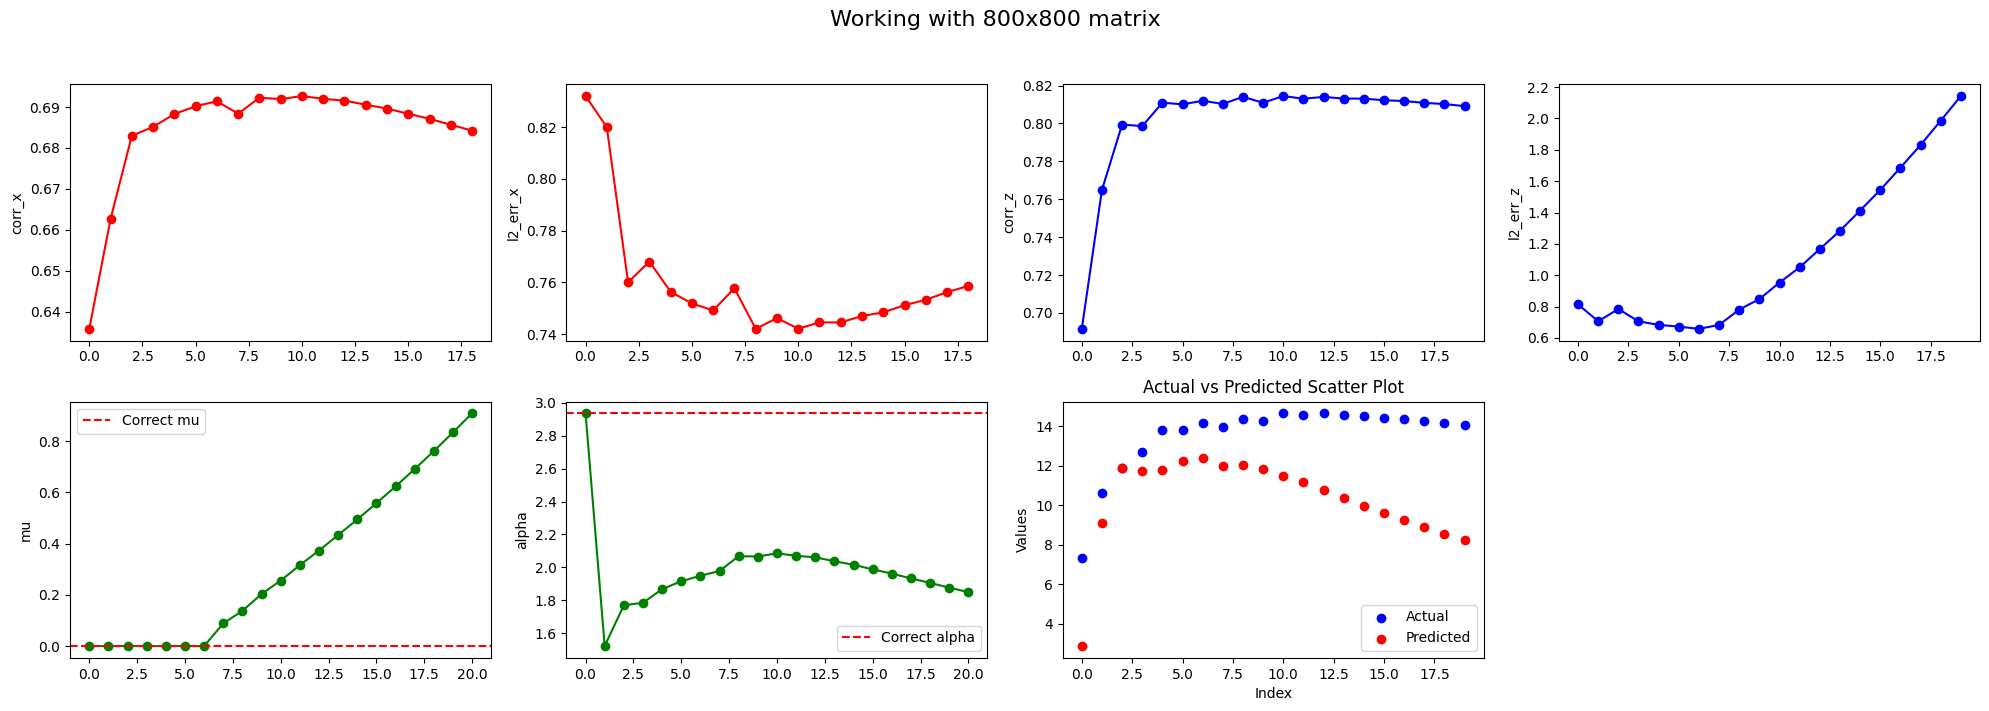

In [9]:
np.random.seed(42)
n=800
m=800
p=0.4
la=0.4
# This is where the sigma is defined. Note that the scope of this definition extends to gvamp
sigma=1
omega=1
h2=0.5
gam1 = 1e-2
tau1 = 1e-1
mu=np.full((n,1), 0) 
maxiter = 20

problem_instance = Problem(n=n, m=m, la=la, sigmas = [sigma], omegas=[omega], model='Weibull', mu=mu)
X,beta,y,alpha = sim_model(problem_instance,h2,p )

print("gam1 = ", gam1)
print("tau1 = ", tau1)
print("alpha = ", alpha)

# we start with an initialization that compleately complies with the assumptions
r1 = np.zeros((m,1))
#r1 = beta + random.normal(loc=0.0, scale=np.sqrt(1.0/gam1), size=[m,1])
p1 = np.zeros((n,1)) 
#p1 = X @ beta + random.normal(loc=0.0, scale=np.sqrt(1.0/tau1), size=[n,1])
problem_instance.prior_instance.distribution_parameters['alpha']=alpha

est, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, a, ps, dl_dmus, z1_hats =  infere(X, y, gam1, r1, tau1, p1, problem_instance, maxiter, beta, True, True)
plot_metrics(corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, dl_dmus, a, ps, mu[0][0], alpha, n, m)

Weibull
gam1 =  0.01
tau1 =  0.1
alpha =  18.644163165242592
s.shape =  (10,)
**** iteration =  0  **** 

->DENOISING
x1_hat[2] =  [0.]
B / (A+B) =  [0.39880656]
gam1 / (gam1 + 1/sigma) =  0.009900990099009901
alpha1 part I =  [0.00394858]
alpha2 part II =  [0.]
alpha1 =  0.003948579767497003
true gam2 =  1.3445472989277858
gam2 =  2.5225561565998147


/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_34435/2211291991.py:16: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  out[i] = scipy.optimize.fsolve(den_z_non_lin_eq_Weibull, x0 = p1[i], args=(tau1, p1[i], y[i], alpha, mu) )
/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_34435/2211291991.py:9: RuntimeWarning: overflow encountered in exp
  res = tau1 * (z-p1) + alpha - alpha * np.power(y, alpha) * np.exp(- alpha * (mu + z) - emc)


corr(z1_hat, X*beta_true) =  0.7124557384405856
l2 error for z1_hat =  0.707278164175877
v1 =  0.0019063304962284506
true tau2 =  288.775496751036
tau2 = 52.35680127231004
->LMMSE
corr(x2_hat, beta_true) =  [[0.9935882]]
l2 error for x2_hat =  0.24597176424555478
alpha2 =  0.08343825314320316
true gam1 =  45.05890374975409
gam1 =  27.71005372642841
corr(z2_hat, beta_true) =  [[0.98919321]]
l2 error for z2_hat =  0.31469225484390945
true tau1 =  3506.397158247353
tau1 =  4517.487092113762


**** iteration =  1  **** 

->DENOISING
x1_hat[2] =  [-1.67843356]
corr(x1_hat, beta_true) =  0.9949410614218371
l2 error for x1_hat =  0.21468534183391938
B / (A+B) =  [0.11336789]
gam1 / (gam1 + 1/sigma) =  0.9651689958671351
alpha1 part I =  [0.10941917]
alpha2 part II =  [0.00529638]
alpha1 =  0.6119681689833596
true gam2 =  19.042176950450976
gam2 =  17.570166930247428
corr(z1_hat, X*beta_true) =  0.9940654852544766
l2 error for z1_hat =  0.3181539054125836
v1 =  0.9926695690740773
true tau2 =  

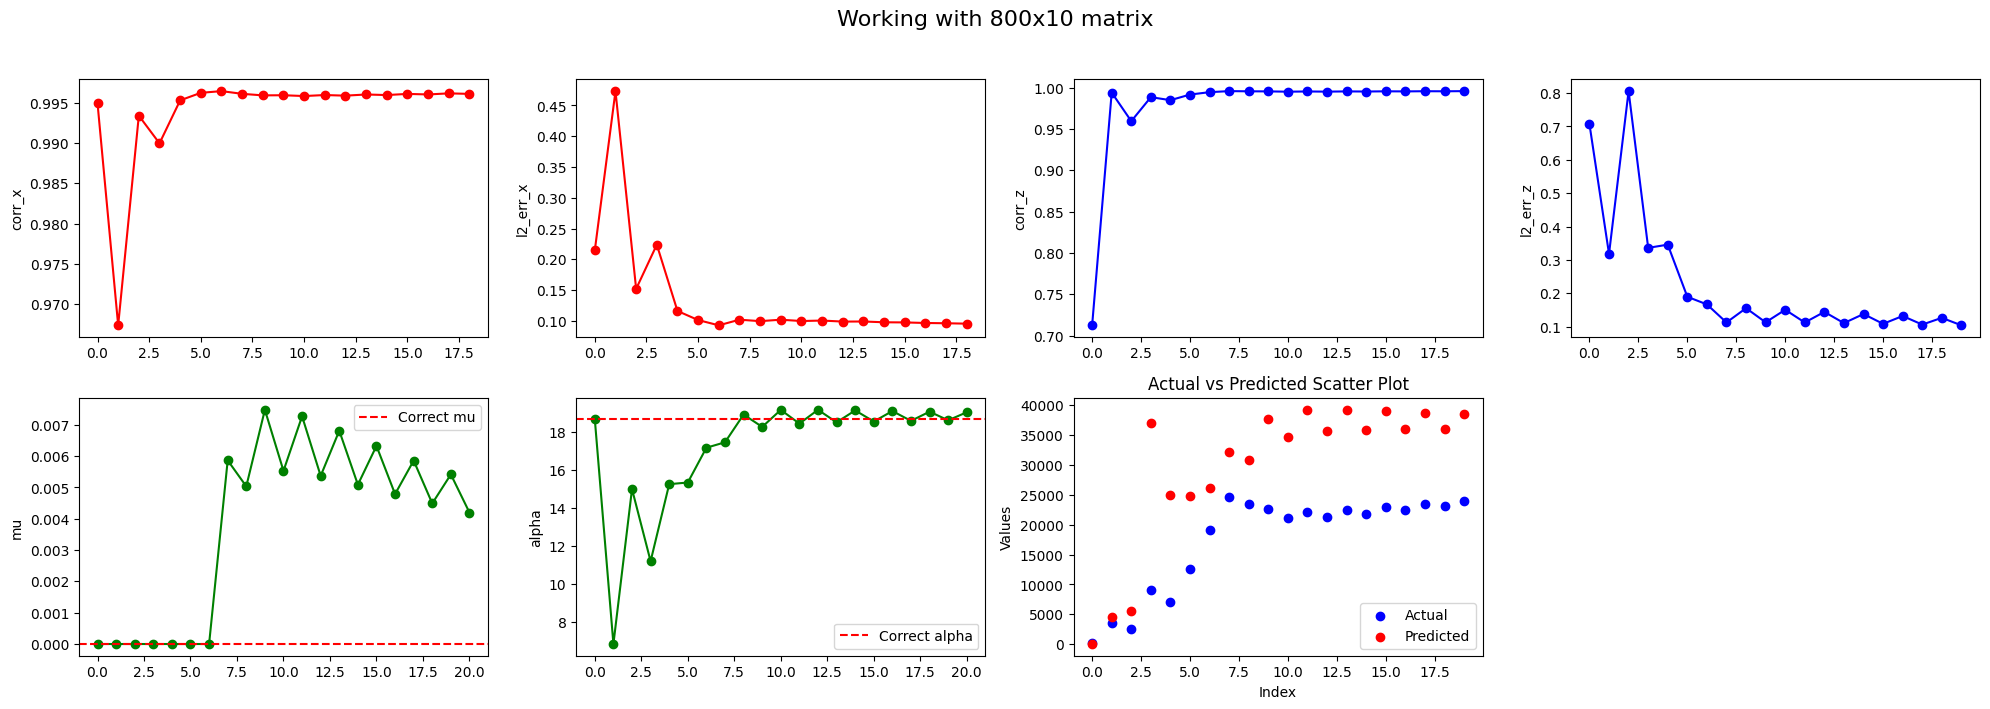

In [10]:
np.random.seed(42)
n=800
m=10
p=0.4
la=0.4
# This is where the sigma is defined. Note that the scope of this definition extends to gvamp
sigma=1
omega=1
h2=0.5
gam1 = 1e-2
tau1 = 1e-1
mu=np.full((n,1), 0) 
maxiter = 20
problem_instance = Problem(n=n, m=m, la=la, sigmas = [sigma], omegas=[omega], model='Weibull', mu=mu)
X,beta,y,alpha = sim_model(problem_instance,h2,p )

print("gam1 = ", gam1)
print("tau1 = ", tau1)
print("alpha = ", alpha)

# we start with an initialization that compleately complies with the assumptions
r1 = np.zeros((m,1))
#r1 = beta + random.normal(loc=0.0, scale=np.sqrt(1.0/gam1), size=[m,1])
p1 = np.zeros((n,1)) 
#p1 = X @ beta + random.normal(loc=0.0, scale=np.sqrt(1.0/tau1), size=[n,1])
problem_instance.prior_instance.distribution_parameters['alpha']=alpha

est, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, a, ps, dl_dmus, z1_hats =  infere(X, y, gam1, r1, tau1, p1, problem_instance, maxiter, beta, True, True)
plot_metrics(corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, dl_dmus, a, ps, mu[0][0], alpha, n, m)

Algorithm is stable if we fix mu to be empirical average of Log(Y)

Weibull
gam1 =  177.43139449749688
tau1 =  0.1
alpha =  2.9361235628007685
s.shape =  (800,)
**** iteration =  0  **** 

->DENOISING
x1_hat[2] =  [0.]
B / (A+B) =  [0.0475359]
gam1 / (gam1 + 1/sigma) =  0.9943956050849895
alpha1 part I =  [0.04726949]
alpha2 part II =  [0.]
alpha1 =  0.047269490109049454
true gam2 =  2.3722202522924425
gam2 =  3576.1820692434358


/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_34435/2211291991.py:16: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  out[i] = scipy.optimize.fsolve(den_z_non_lin_eq_Weibull, x0 = p1[i], args=(tau1, p1[i], y[i], alpha, mu) )


corr(z1_hat, X*beta_true) =  0.6730481288913023
l2 error for z1_hat =  0.852346613814433
v1 =  0.03881657471125915
true tau2 =  6.709694065071083
tau2 = 2.476219069916903
->LMMSE
corr(x2_hat, beta_true) =  [[0.32036978]]
l2 error for x2_hat =  0.9997487100395009
alpha2 =  0.9993414741933273
true gam1 =  3.2620618651488607
gam1 =  2.356560037556662
corr(z2_hat, beta_true) =  [[0.39614504]]
l2 error for z2_hat =  0.9922137791750816
true tau1 =  5.240728582997621
tau1 =  3757.769840880857


**** iteration =  1  **** 

->DENOISING
x1_hat[2] =  [0.04449724]
corr(x1_hat, beta_true) =  0.5325236917579811
l2 error for x1_hat =  0.9189676644271716
B / (A+B) =  [0.45926362]
gam1 / (gam1 + 1/sigma) =  0.7020759382191987
alpha1 part I =  [0.32243793]
alpha2 part II =  [0.29557032]
alpha1 =  0.41488829049158826
true gam2 =  2.4500438477050936
gam2 =  3.32342682050686
corr(z1_hat, X*beta_true) =  0.5185992557184835
l2 error for z1_hat =  0.9921922014391018
v1 =  0.9994544618958636
true tau2 =  4.275

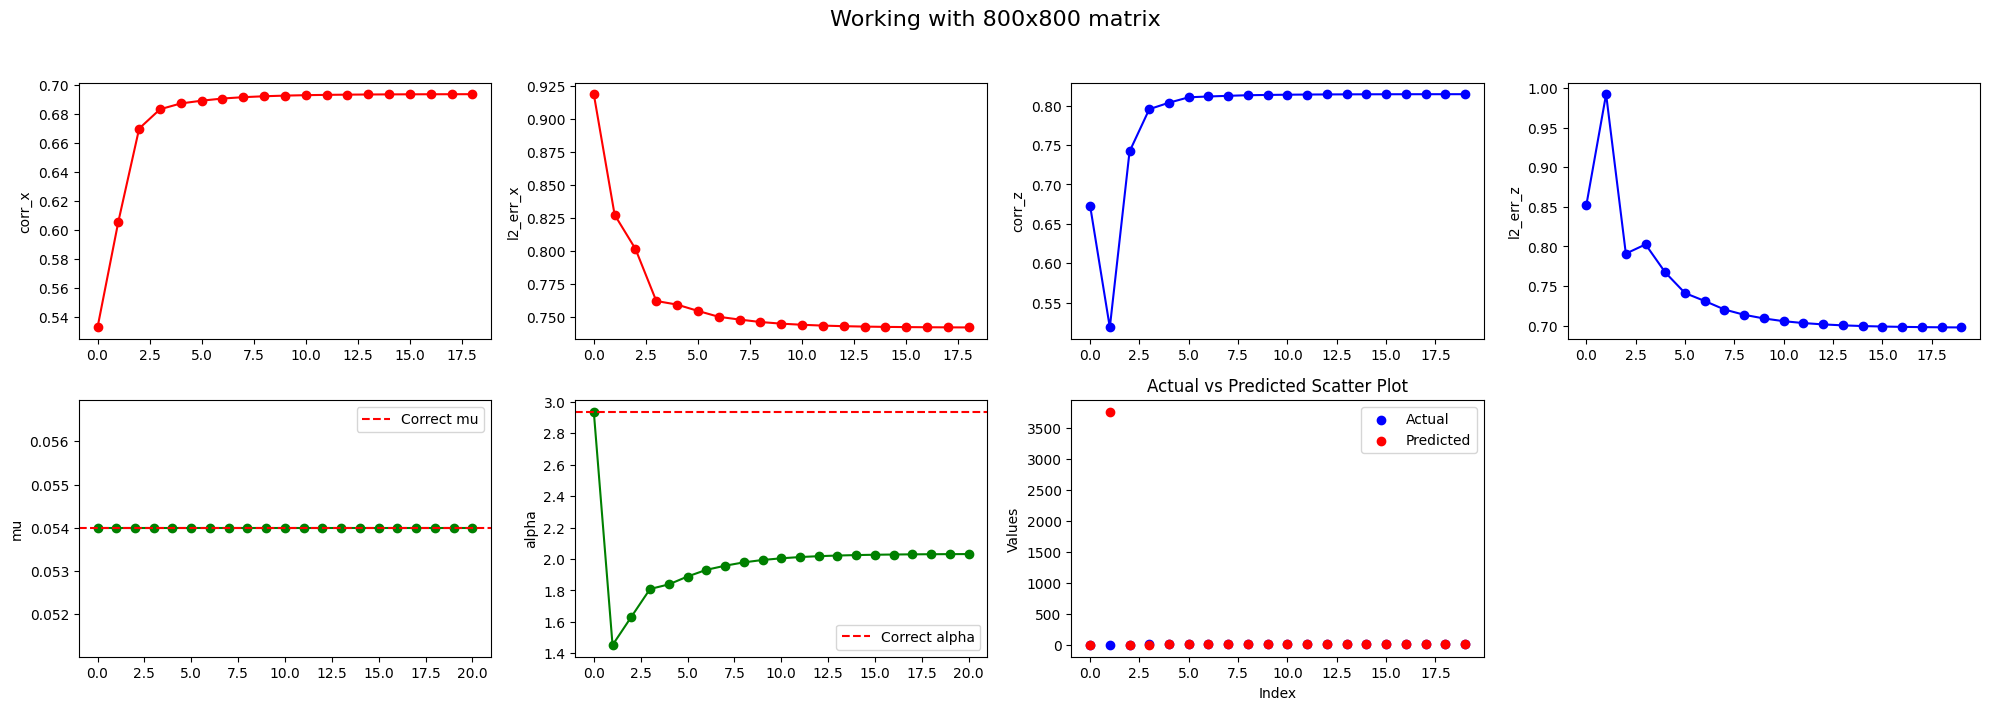

In [11]:
np.random.seed(42)
n=800
m=800
mu=np.mean(np.log(y)).reshape(-1, 1)
r1 = np.zeros((m,1))
p1 = np.zeros((n,1))

problem_instance = Problem(n=n, m=m, la=la, sigmas = [sigma], omegas=[omega], model='Weibull', mu=mu)
X,beta,y,alpha = sim_model(problem_instance,h2,p )

print("gam1 = ", gam1)
print("tau1 = ", tau1)
print("alpha = ", alpha)

# we start with an initialization that compleately complies with the assumptions
r1 = np.zeros((m,1))
#r1 = beta + random.normal(loc=0.0, scale=np.sqrt(1.0/gam1), size=[m,1])
p1 = np.zeros((n,1)) 
#p1 = X @ beta + random.normal(loc=0.0, scale=np.sqrt(1.0/tau1), size=[n,1])
problem_instance.prior_instance.distribution_parameters['alpha']=alpha

est, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, a, ps, dl_dmus, z1_hats =  infere(X, y, gam1, r1, tau1, p1, problem_instance, maxiter, beta, False, True)
plot_metrics(corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, dl_dmus, a, ps, mu[0][0], alpha, n, m)

Weibull
gam1 =  1.2175969767939998
tau1 =  0.1
alpha =  2.9361235628007685
s.shape =  (800,)
**** iteration =  0  **** 

->DENOISING
x1_hat[2] =  [0.]
B / (A+B) =  [0.30923948]
gam1 / (gam1 + 1/sigma) =  0.5490614343072793
alpha1 part I =  [0.16979147]
alpha2 part II =  [0.]
alpha1 =  0.16979147350357418
true gam2 =  2.3722202522924425
gam2 =  5.953534480336378


/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_34435/2211291991.py:16: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  out[i] = scipy.optimize.fsolve(den_z_non_lin_eq_Weibull, x0 = p1[i], args=(tau1, p1[i], y[i], alpha, mu) )


corr(z1_hat, X*beta_true) =  0.6730481288913023
l2 error for z1_hat =  0.852346613814433
v1 =  0.03881657471125915
true tau2 =  6.709694065071083
tau2 = 2.476219069916903
->LMMSE
corr(x2_hat, beta_true) =  [[0.56950146]]
l2 error for x2_hat =  0.9052393122387166
alpha2 =  0.8534323118285042
true gam1 =  1.9651842318018131
gam1 =  1.0224545908774276
corr(z2_hat, beta_true) =  [[0.75121478]]
l2 error for z2_hat =  0.8166776267024518
true tau1 =  6.317904960140364
tau1 =  14.41849422473185


**** iteration =  1  **** 

->DENOISING
x1_hat[2] =  [-0.09859489]
corr(x1_hat, beta_true) =  0.6112554622181562
l2 error for x1_hat =  0.8389128505616708
B / (A+B) =  [0.3616261]
gam1 / (gam1 + 1/sigma) =  0.5055513213939913
alpha1 part I =  [0.18282055]
alpha2 part II =  [0.0441874]
alpha1 =  0.2247444376399134
true gam2 =  2.5747041321805426
gam2 =  3.526955403934587
corr(z1_hat, X*beta_true) =  0.7370164578497688
l2 error for z1_hat =  0.8285579593332606
v1 =  0.894845653200446
true tau2 =  5.4821

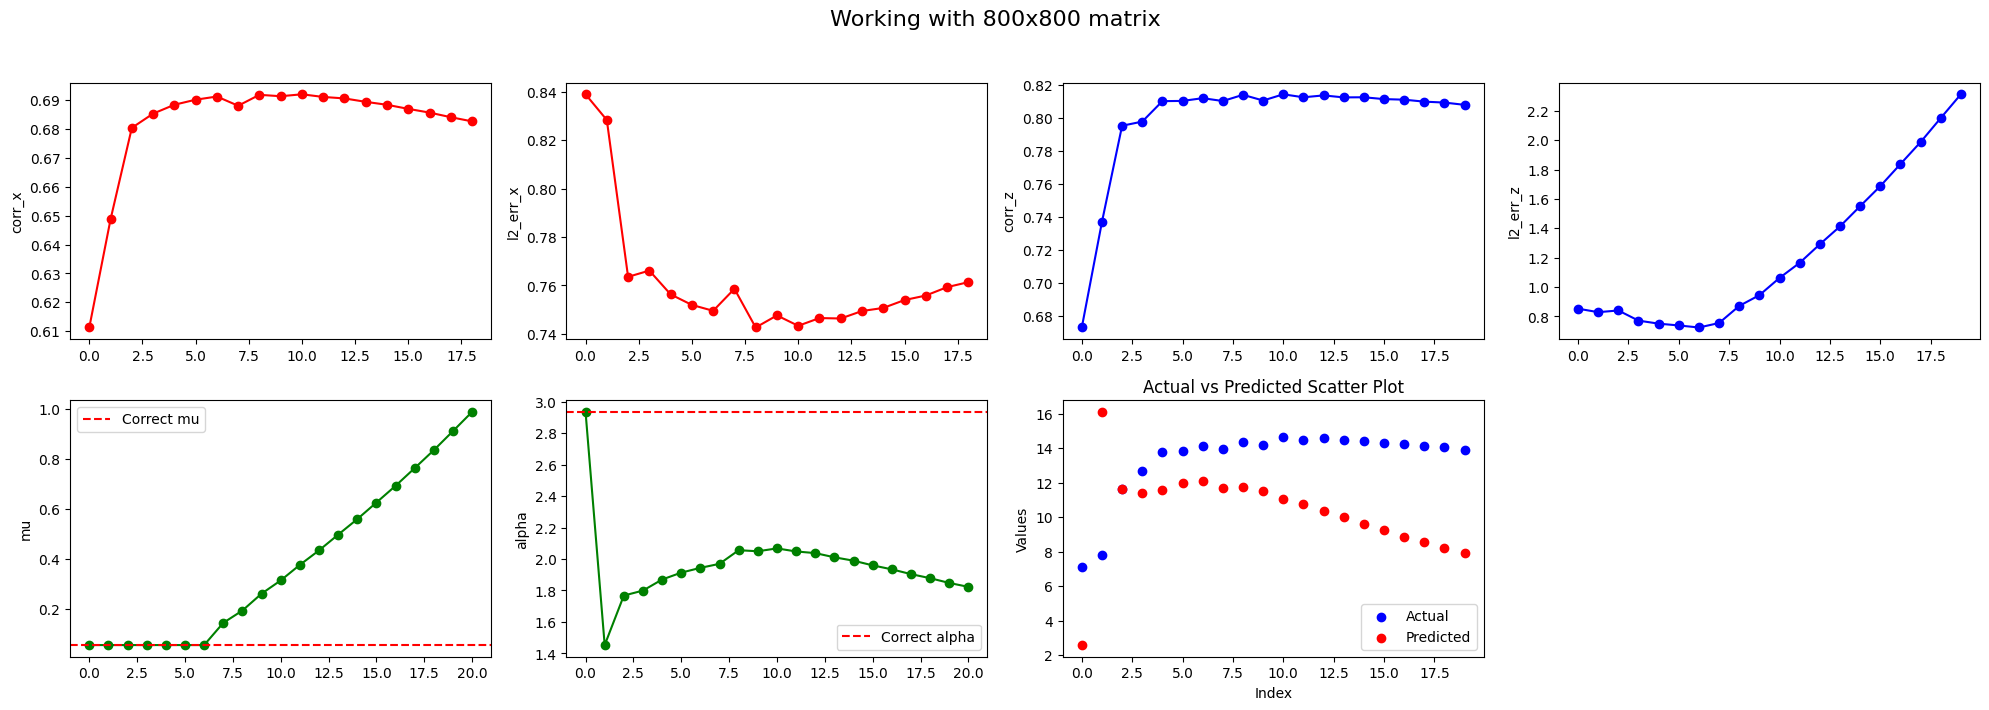

In [12]:
np.random.seed(42)
n=800
m=800
r1 = np.zeros((m,1))
p1 = np.zeros((n,1))

problem_instance = Problem(n=n, m=m, la=la, sigmas = [sigma], omegas=[omega], model='Weibull', mu=mu)
X,beta,y,alpha = sim_model(problem_instance,h2,p )

print("gam1 = ", gam1)
print("tau1 = ", tau1)
print("alpha = ", alpha)

# we start with an initialization that compleately complies with the assumptions
r1 = np.zeros((m,1))
#r1 = beta + random.normal(loc=0.0, scale=np.sqrt(1.0/gam1), size=[m,1])
p1 = np.zeros((n,1)) 
#p1 = X @ beta + random.normal(loc=0.0, scale=np.sqrt(1.0/tau1), size=[n,1])
problem_instance.prior_instance.distribution_parameters['alpha']=alpha

est, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, a, ps, dl_dmus, z1_hats =  infere(X, y, gam1, r1, tau1, p1, problem_instance, maxiter, beta, True, True)
plot_metrics(corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, dl_dmus, a, ps, mu[0][0], alpha, n, m)